# Dual identification of novel phage receptor-binding proteins based on protein domains and machine learning

This notebook serves as the main document of code and analyses for the detection of phage RBPs in genomes and metagenomes.

## 0. Libraries

In [1]:
import os
import re
import subprocess
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import RBPdetection_utils as rbpu
from random import sample
from Bio import SeqIO, Entrez
from tqdm.notebook import tqdm
from xgboost import XGBClassifier
from sklearn.manifold import TSNE
from sklearn.svm import OneClassSVM
from sklearn.decomposition import PCA
from sklearn.neural_network import MLPClassifier
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler, label_binarize
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, IsolationForest
from sklearn.model_selection import GridSearchCV, StratifiedKFold, GroupKFold, cross_val_predict, train_test_split
from sklearn.metrics import precision_score, roc_auc_score, make_scorer, roc_curve, confusion_matrix, f1_score, accuracy_score
%matplotlib inline

In [2]:
# set directories
pfam_file = '/Users/Dimi/GoogleDrive/PhD/3_PHAGEBASE/32_DATA/RBP_detection/Pfam-A_extended.hmm'
hmm_path = '/Users/Dimi/hmmer-3.3.1'
data_dir = '/Users/Dimi/GoogleDrive/PhD/3_PHAGEBASE/32_DATA/RBP_detection'
results_dir = '/Users/Dimi/GoogleDrive/PhD/3_PHAGEBASE/33_RESULTS/RBP_detection'
phanns_dir = '/Users/dimi/Documents/GitHub/PhANNs-master/web_server'

## 1. Loading and processing data

1. Get most recent MillardLab data from their GitHub (https://github.com/RyanCook94/inphared): download the tsv file (filtered genomes with information on name, host, family etc) and unfiltered GenBank file of phage genomes (to extract relevant records from) from their website.
2. The functions RBP_collection and RBP_filters will process the MilalrdLab data into two sets of phage RBPs and nonRBPs based on available annotation, and applying several filters to ensure quality (deleting dubious annotations, short proteins, etc...)
3. The final RBP and nonRBP datasets are also timestamped for easy recollection in the future.
4. Finally, the RBPs and nonRBPs are transformed into protein embeddings: cfr protein_embeddings_cloud (too intensive for local computer, so compute with GPU in Kaggle notebooks).

#### Collecting and processing MillardLab data

In [13]:
def RBP_collection(MillardLab_tsv, MillardLab_genbank, directory):
    """
    This function loops over the filtered and unfiltered phage genome data of MillardLab to construct a collection of 
    (unfiltered) RBP and nonRBP sequence records for further analysis.
    
    Input:
    - MillardLab_tsv: handle (string) to the filtered tsv file of MillardLab phage genomes
    - MillardLab_genbank: handle (string) to the unfiltered phage genomes downloaded from NCBI by MillardLab
    - directory: string of location to store the sequence file at.

    Output: Dataframes of RBPs and nonRBPs
    """

    # load input data & make dict
    tsv_data = pd.read_csv(MillardLab_tsv, sep='\t')
    records = SeqIO.parse(MillardLab_genbank, 'gb')
    rbp_dict = {'phage_id':[], 'protein_id': [], 'Organism': [], 'Host':[], 'ProteinName': [], 'ProteinSeq': [], 
                'DNASeq': [], 'RecordDate': []}
    nonrbp_dict = {'phage_id':[], 'protein_id': [], 'Organism': [], 'Host':[], 'ProteinName': [], 'ProteinSeq': [], 
                'DNASeq': [], 'RecordDate': []}
    rbp_re = r'tail.?(?:spike|fib(?:er|re))|^recept(?:o|e)r.?(?:binding|recognizing).*(?:protein)?|^RBP'

    # loop over all records
    stop_iter = 0
    while stop_iter >= 0:
        try:
            record = next(records)
            rindex = list(tsv_data['Accession']).index(record.name)
            record_realm = tsv_data['Realm'][rindex]
            # if in filtered tsv data and is phage, check the CDSs
            if (record.name in list(tsv_data['Accession'])) and (record_realm in ['Duplodnaviria', 'Unclassified']):
                host = '-'
                if 'host' in record.features[0].qualifiers:
                    host = record.features[0].qualifiers['host'][0]
                elif 'lab_host' in record.features[0].qualifiers:
                    host = record.features[0].qualifiers['lab_host'][0]
                elif 'strain' in record.features[0].qualifiers:
                    host = record.features[0].qualifiers['strain'][0]
                org = record.annotations['organism']
                date = record.annotations['date']
                
                # look for the CDSs and get their infos
                for feature in record.features:
                    if feature.type == 'CDS':
                        try:
                            pname = feature.qualifiers['product'][0]
                            pseq = feature.qualifiers['translation'][0]
                            dnaseq = str(feature.location.extract(record).seq)
                            pid = feature.qualifiers['protein_id'][0]
                            
                            # collect in RBPs or nonRBPs
                            if re.search(rbp_re, pname, re.IGNORECASE) is not None:
                                rbp_dict['phage_id'].append(record.name)
                                rbp_dict['protein_id'].append(pid)
                                rbp_dict['Organism'].append(org)
                                rbp_dict['Host'].append(host)
                                rbp_dict['ProteinName'].append(pname)
                                rbp_dict['ProteinSeq'].append(pseq)
                                rbp_dict['DNASeq'].append(dnaseq)
                                rbp_dict['RecordDate'].append(date)
                            else:
                                nonrbp_dict['phage_id'].append(record.name)
                                nonrbp_dict['protein_id'].append(pid)
                                nonrbp_dict['Organism'].append(org)
                                nonrbp_dict['Host'].append(host)
                                nonrbp_dict['ProteinName'].append(pname)
                                nonrbp_dict['ProteinSeq'].append(pseq)
                                nonrbp_dict['DNASeq'].append(dnaseq)
                                nonrbp_dict['RecordDate'].append(date)    
                        except KeyError:
                            pass
                        
            stop_iter += 1         
            if stop_iter%1000 == 0:
                print('iteration:', stop_iter)
        except StopIteration:
            stop_iter = -1
        except:
            pass
    
    # make dataframe and save
    annotated_rbps = pd.DataFrame(data=rbp_dict)
    annotated_nonrbps = pd.DataFrame(data=nonrbp_dict)
    annotated_rbps.to_csv(directory+'/annotated_RBPs_unfiltered.csv', index=False)
    annotated_nonrbps.to_csv(directory+'/annotated_nonRBPs_unfiltered.csv', index=False)
    print('Wrote RBP and nonRBP databases to directory.')

    return

In [14]:
def RBP_filters(RBPs_unfiltered, nonRBPs_unfiltered, directory, timestamp):
    """
    This function applies several data processing filters to both the annotated RBP and annotated nonRBP set.
    
    Inputs:
    - RBPs_unfiltered: unfiltered annotated RBPs, DataFrame
    - nonRBPs_unfiltered: unfiltered annotated nonRBPs, DataFrame
    - directory: to store output files in
    - timestamp: current month/year for saving (e.g. '2020-01')
    
    Output: filtered RBP and nonRBP databases
    """
    to_delete_rbps = []
    to_delete_nonrbps = []
    keywords = ['adaptor','wedge','baseplate','hinge','connector','structural','component',
                'assembly','chaperone','attachment','capsid','proximal','measure']
    hypotheticals = ['probable','probably','uncharacterized','uncharacterised','putative',
                     'hypothetical','unknown','predicted']
    
    # loop over RBPs
    for i, rbpseq in enumerate(RBPs_unfiltered['ProteinSeq']):
        rbpname = RBPs_unfiltered['ProteinName'][i]
        
        # filter unknown AAs
        if re.search(r'[^ACDEFGHIKLMNPQRSTVWY]', rbpseq) is not None:
            to_delete_rbps.append(i)
        # filter keywords
        if any(key in rbpname.lower() for key in keywords):
            to_delete_rbps.append(i)
        # filter length
        if (len(rbpseq) < 200) or (len(rbpseq) > 2000):
            to_delete_rbps.append(i)
            
    # loop over nonRBPs
    for i, nonrbpseq in enumerate(nonRBPs_unfiltered['ProteinSeq']):
        nonrbpname = nonRBPs_unfiltered['ProteinName'][i]
        
        # filter unknown AAs
        if re.search(r'[^ACDEFGHIKLMNPQRSTVWY]', nonrbpseq) is not None:
            to_delete_nonrbps.append(i)
        # filter hypotheticals
        if any(hyp in nonrbpname.lower() for hyp in hypotheticals):
            to_delete_nonrbps.append(i)
        # filter length
        if len(nonrbpseq) < 30:
            to_delete_nonrbps.append(i)
            
    # delete
    to_delete_rbps = list(set(to_delete_rbps))
    to_delete_nonrbps = list(set(to_delete_nonrbps))
    RBPs = RBPs_unfiltered.drop(to_delete_rbps)
    RBPs = RBPs.reset_index(drop=True)
    nonRBPs = nonRBPs_unfiltered.drop(to_delete_nonrbps)
    nonRBPs = nonRBPs.reset_index(drop=True)
    
    # filter identicals
    RBPs.drop_duplicates(subset = ['ProteinSeq'], inplace = True)
    nonRBPs.drop_duplicates(subset = ['ProteinSeq'], inplace = True)
    
    # filter dubious ones (RBP-nonRBPs identicals)
    to_delete_dubiousRBPs = [i for i, sequence in enumerate(RBPs['ProteinSeq']) if sequence in nonRBPs['ProteinSeq']]
    to_delete_dubiousnonRBPs = [i for i, sequence in enumerate(nonRBPs['ProteinSeq']) if sequence in RBPs['ProteinSeq']]
    RBPs = RBPs.drop(to_delete_dubiousRBPs)
    RBPs = RBPs.reset_index(drop=True)
    nonRBPs = nonRBPs.drop(to_delete_dubiousnonRBPs)
    nonRBPs = nonRBPs.reset_index(drop=True)
    print(RBPs.shape, nonRBPs.shape)
    
    # save new databases
    RBPs.to_csv(directory+'/annotated_RBPs_'+timestamp+'.csv', index=False)
    nonRBPs.to_csv(directory+'/annotated_nonRBPs_'+timestamp+'.csv', index=False)
    print('Wrote filtered databases to directory.')
    
    return

In [15]:
# load data and collect CDSs
Millard_tsv = data_dir+'/MillardLab_data_2021-12.tsv'
Millard_gb = data_dir+'/MillardLab_genbank_2021-12.gb.txt'
RBP_collection(Millard_tsv, Millard_gb, data_dir)

iteration: 1000
iteration: 2000
iteration: 3000
iteration: 4000
iteration: 5000
iteration: 6000
iteration: 7000
iteration: 8000
iteration: 9000
iteration: 10000
iteration: 11000
iteration: 12000
iteration: 13000
iteration: 14000
iteration: 15000
iteration: 16000
iteration: 17000
iteration: 18000
iteration: 19000
iteration: 20000
iteration: 21000
Wrote RBP and nonRBP databases to directory.


In [16]:
# process & filter collected CDSs
rbps_uf = pd.read_csv(data_dir+'/annotated_RBPs_unfiltered.csv')
nonrbps_uf = pd.read_csv(data_dir+'/annotated_nonRBPs_unfiltered.csv')
print(rbps_uf.shape, nonrbps_uf.shape)
RBP_filters(rbps_uf, nonrbps_uf, data_dir, '2022-01')

(16496, 8) (1811032, 8)
(6176, 8) (228315, 8)
Wrote filtered databases to directory.


In [31]:
# load processed data
rbps = pd.read_csv(data_dir+'/annotated_RBPs_2022-01.csv')
nonrbps = pd.read_csv(data_dir+'/annotated_nonRBPs_2022-01.csv')

In [38]:
rbps.head()

,phage_id,protein_id,Organism,Host,ProteinName,ProteinSeq,DNASeq,RecordDate
0,OL441337,UFK26514.1,Pseudomonas phage PaP_Se,Pseudomonas aeruginosa,tail fibers protein,MGLEVATYINQLVPTNPTGSDLKSFGDDHLRLIKSAIKNTFPNISQ...,ATGGGTCTTGAGGTCGCAACTTATATTAACCAGTTGGTGCCTACGA...,28-NOV-2021
1,OK625527,UFK26377.1,Klebsiella phage vB_KpnP_ZK1,Klebsiella pneumoniae,tail fibers protein,MEVQGSLGRQIQGISQQPASVRLPGQCTDAINCSMDVVEGTKSRPG...,ATGGAAGTTCAAGGCTCGTTAGGTCGGCAGATACAAGGTATCAGCC...,28-NOV-2021
2,OK562429,UFJ83549.1,Klebsiella phage P929,Klebsiella pneumoniae Kp325,non-contractile tail fiber protein,MAFSWQEQIKPAGTQDIQCDIEYLDKSYIHVYLDGEETTGYTWTSS...,ATGGCGTTCAGCTGGCAAGAACAAATCAAGCCAGCTGGTACCCAGG...,28-NOV-2021
3,OK546191,UFJ83440.1,Acinetobacter phage vB_AbaP_ABWU2101,Acinetobacter baumannii,tailspike protein,MNILRSFTETVVTTPTELFPISFEYDEKYDAVHVFLNDVAVEDLGY...,ATGAATATACTACGCTCATTTACAGAGACAGTGGTGACTACACCTA...,28-NOV-2021
4,MZ675741,UFJ83225.1,Acinetobacter phage Ab1656-2,Acinetobacter baumannii 1656-2,putative tail fiber,MANLVFKFSWDHRPFPYNASQGKRQFMLPFASGIPNLAPNFSQVVG...,ATGGCAAATCTTGTTTTTAAATTTAGTTGGGATCATCGGCCATTCC...,28-NOV-2021


#### Computing embeddings

This is done in the protein_embeddings_cloud notebook on Kaggle, utilizing a GPU for speedup.

## 2. Constructing custom RBP domain HMMs

## 3. Learning patterns and evaluating models

Here, we build an XGBoost classifier to discriminate between phage RBPs and phage nonRBPs, as defined in the processing above. We train our model on all data before October 2021. This allows for a separate and final benchmark against PhANNs using the sequence data that only became available during the last three months of 2021. Therefore, the embeddings that were computed in the cloud also include the record data of each corresponding data point. Then we split according to this date.

Findings:
- we see that standard scaling does not affect peformance.
- the One-class approaches don't seem to work, at least not at a split of 1:10. Perhaps the high dimensionality is also a problem...
- The XGBoost classifier seems to work best so far.
- The AUC metric considers both the majority and minority class, which can give an overly optimistic estimate of performance. The F1 score considers only the positive/minority class.

#### Load processed data  & filter up to SEP 2021

In [31]:
rbps_em = pd.read_csv(data_dir+'/annotated_RBPs_2022-01_embeddings.csv')
nonrbps_em = pd.read_csv(data_dir+'/annotated_nonRBPs_2022-01_embeddings.csv')
months = ['OCT-2021', 'NOV-2021', 'DEC-2021']
to_delete_rbps = [i for i, date in enumerate(rbps_em['RecordDate']) if any(x in date for x in months)]
rbps_upto2021 = rbps_em.drop(to_delete_rbps)
rbps_upto2021 = rbps_upto2021.reset_index(drop=True)
to_delete_nonrbps = [i for i, date in enumerate(nonrbps_em['RecordDate']) if any(x in date for x in months)]
nonrbps_upto2021 = nonrbps_em.drop(to_delete_nonrbps)
nonrbps_upto2021 = nonrbps_upto2021.reset_index(drop=True)

rbp_embed = np.asarray(rbps_upto2021.iloc[:, 2:])
nonrbp_embed = np.asarray(nonrbps_upto2021.iloc[:, 2:])

features = np.concatenate((rbp_embed, nonrbp_embed))
labels = np.asarray([1]*rbp_embed.shape[0] + [0]*nonrbp_embed.shape[0])
print('Check?', features.shape[0]==labels.shape[0])
print('Check?', features.shape[1]==1024)

Check? True
Check? True


#### Explore the embeddings with PCA & tSNE

In [35]:
# PCA to visualize class separation
pca = PCA(n_components=5)
fr_pca = pca.fit_transform(features)
print(pca.explained_variance_ratio_, sum(pca.explained_variance_ratio_))

tsne = TSNE(n_components=3)
fr_tsne = tsne.fit_transform(features)

[0.21927851 0.16474411 0.13806368 0.0748293  0.0392286 ] 0.6361441929158258


/opt/homebrew/Caskroom/miniforge/base/envs/ML1/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/opt/homebrew/Caskroom/miniforge/base/envs/ML1/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


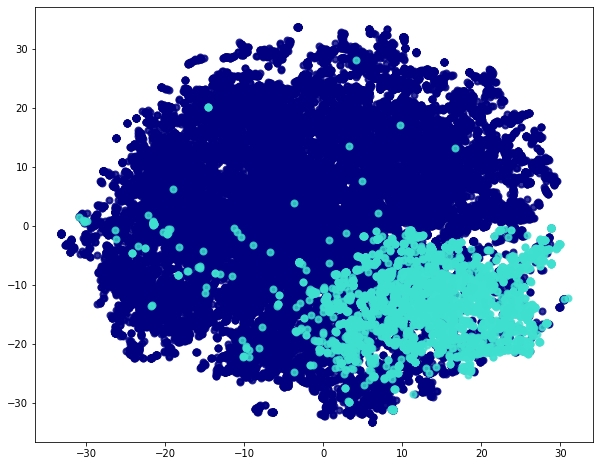

In [36]:
fr = fr_tsne
fig, ax = plt.subplots(figsize=(10, 8))
colors = ["navy", "turquoise"]
for color, i in zip(colors, [0, 1]):
    ax.scatter(fr[labels == i, 0], fr[labels == i, 1], color=color, alpha=0.8, lw=2)

#### Nested cross-validation: optimize hyperparameters and evaluate model performance

In [11]:
# define cross-validation iterator & models
imbalance = rbp_embed.shape[0]/nonrbp_embed.shape[0]
inner_cv = StratifiedKFold(n_splits=2, shuffle=True)
outer_cv = StratifiedKFold(n_splits=4, shuffle=True)
performances = {'F1':[], 'P':[], 'AUC':[]}
cpus = 6

xgb = XGBClassifier(scale_pos_weight=1/imbalance, n_jobs=cpus)
params_xgb = {'max_depth': [3, 5], 'n_estimators': [250, 500]}

In [14]:
probabilities = np.zeros((features.shape[0], 2))
preds = np.zeros(features.shape[0])
bar = tqdm(total=4, desc='4-fold CV')

# define outer loop
for train_outer, test_outer in outer_cv.split(features, labels):
    X_train, X_test = features[train_outer], features[test_outer]
    y_train, y_test = labels[train_outer], labels[test_outer]

    # define inner loop (in GridSearchCV)
    tuned_xgb = GridSearchCV(xgb, cv=inner_cv, param_grid=params_xgb, scoring='f1')
    tuned_xgb.fit(X_train, y_train)
    print(tuned_xgb.best_params_)

    # make predictions for test set (outer loop)
    y_probs = tuned_xgb.predict_proba(X_test)
    y_preds = tuned_xgb.predict(X_test)

    # store predictions at the corresponding locations
    for i, index in enumerate(test_outer):
        probabilities[index,:] = y_probs[i,:]
        preds[index] = y_preds[i]
        
    bar.update(1)
bar.close()

4-fold CV:   0%|                                          | 0/4 [24:27<?, ?it/s]
/opt/homebrew/Caskroom/miniforge/base/envs/ML1/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fitting 2 folds for each of 4 candidates, totalling 8 fits
[11:22:26] WARNING: /private/var/folders/p1/fvz7cyr12yl0lf647b14byy80000gn/T/pip-install-w5n3w6k9/xgboost_a8a36401f804426fb00f941f2eae565c/build/temp.macosx-11.0-arm64-3.9/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV] END ......................max_depth=3, n_estimators=250; total time= 1.2min


/opt/homebrew/Caskroom/miniforge/base/envs/ML1/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[11:23:38] WARNING: /private/var/folders/p1/fvz7cyr12yl0lf647b14byy80000gn/T/pip-install-w5n3w6k9/xgboost_a8a36401f804426fb00f941f2eae565c/build/temp.macosx-11.0-arm64-3.9/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV] END ......................max_depth=3, n_estimators=250; total time= 1.3min


/opt/homebrew/Caskroom/miniforge/base/envs/ML1/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[11:24:59] WARNING: /private/var/folders/p1/fvz7cyr12yl0lf647b14byy80000gn/T/pip-install-w5n3w6k9/xgboost_a8a36401f804426fb00f941f2eae565c/build/temp.macosx-11.0-arm64-3.9/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV] END ......................max_depth=3, n_estimators=500; total time= 2.6min


/opt/homebrew/Caskroom/miniforge/base/envs/ML1/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[11:27:34] WARNING: /private/var/folders/p1/fvz7cyr12yl0lf647b14byy80000gn/T/pip-install-w5n3w6k9/xgboost_a8a36401f804426fb00f941f2eae565c/build/temp.macosx-11.0-arm64-3.9/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV] END ......................max_depth=3, n_estimators=500; total time= 2.6min


/opt/homebrew/Caskroom/miniforge/base/envs/ML1/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[11:30:09] WARNING: /private/var/folders/p1/fvz7cyr12yl0lf647b14byy80000gn/T/pip-install-w5n3w6k9/xgboost_a8a36401f804426fb00f941f2eae565c/build/temp.macosx-11.0-arm64-3.9/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV] END ......................max_depth=5, n_estimators=250; total time= 1.9min


/opt/homebrew/Caskroom/miniforge/base/envs/ML1/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[11:32:04] WARNING: /private/var/folders/p1/fvz7cyr12yl0lf647b14byy80000gn/T/pip-install-w5n3w6k9/xgboost_a8a36401f804426fb00f941f2eae565c/build/temp.macosx-11.0-arm64-3.9/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV] END ......................max_depth=5, n_estimators=250; total time= 1.9min


/opt/homebrew/Caskroom/miniforge/base/envs/ML1/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[11:33:58] WARNING: /private/var/folders/p1/fvz7cyr12yl0lf647b14byy80000gn/T/pip-install-w5n3w6k9/xgboost_a8a36401f804426fb00f941f2eae565c/build/temp.macosx-11.0-arm64-3.9/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV] END ......................max_depth=5, n_estimators=500; total time= 2.9min


/opt/homebrew/Caskroom/miniforge/base/envs/ML1/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[11:36:50] WARNING: /private/var/folders/p1/fvz7cyr12yl0lf647b14byy80000gn/T/pip-install-w5n3w6k9/xgboost_a8a36401f804426fb00f941f2eae565c/build/temp.macosx-11.0-arm64-3.9/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV] END ......................max_depth=5, n_estimators=500; total time= 2.9min


/opt/homebrew/Caskroom/miniforge/base/envs/ML1/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[11:39:43] WARNING: /private/var/folders/p1/fvz7cyr12yl0lf647b14byy80000gn/T/pip-install-w5n3w6k9/xgboost_a8a36401f804426fb00f941f2eae565c/build/temp.macosx-11.0-arm64-3.9/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


4-fold CV:  25%|███████▌                      | 1/4 [25:00<1:15:01, 1500.56s/it]/opt/homebrew/Caskroom/miniforge/base/envs/ML1/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fitting 2 folds for each of 4 candidates, totalling 8 fits
[11:47:27] WARNING: /private/var/folders/p1/fvz7cyr12yl0lf647b14byy80000gn/T/pip-install-w5n3w6k9/xgboost_a8a36401f804426fb00f941f2eae565c/build/temp.macosx-11.0-arm64-3.9/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV] END ......................max_depth=3, n_estimators=250; total time= 1.5min


/opt/homebrew/Caskroom/miniforge/base/envs/ML1/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[11:48:54] WARNING: /private/var/folders/p1/fvz7cyr12yl0lf647b14byy80000gn/T/pip-install-w5n3w6k9/xgboost_a8a36401f804426fb00f941f2eae565c/build/temp.macosx-11.0-arm64-3.9/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV] END ......................max_depth=3, n_estimators=250; total time= 1.5min


/opt/homebrew/Caskroom/miniforge/base/envs/ML1/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[11:50:21] WARNING: /private/var/folders/p1/fvz7cyr12yl0lf647b14byy80000gn/T/pip-install-w5n3w6k9/xgboost_a8a36401f804426fb00f941f2eae565c/build/temp.macosx-11.0-arm64-3.9/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV] END ......................max_depth=3, n_estimators=500; total time= 2.7min


/opt/homebrew/Caskroom/miniforge/base/envs/ML1/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[11:53:02] WARNING: /private/var/folders/p1/fvz7cyr12yl0lf647b14byy80000gn/T/pip-install-w5n3w6k9/xgboost_a8a36401f804426fb00f941f2eae565c/build/temp.macosx-11.0-arm64-3.9/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV] END ......................max_depth=3, n_estimators=500; total time= 2.7min


/opt/homebrew/Caskroom/miniforge/base/envs/ML1/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[11:55:44] WARNING: /private/var/folders/p1/fvz7cyr12yl0lf647b14byy80000gn/T/pip-install-w5n3w6k9/xgboost_a8a36401f804426fb00f941f2eae565c/build/temp.macosx-11.0-arm64-3.9/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV] END ......................max_depth=5, n_estimators=250; total time= 1.9min


/opt/homebrew/Caskroom/miniforge/base/envs/ML1/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[11:57:39] WARNING: /private/var/folders/p1/fvz7cyr12yl0lf647b14byy80000gn/T/pip-install-w5n3w6k9/xgboost_a8a36401f804426fb00f941f2eae565c/build/temp.macosx-11.0-arm64-3.9/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV] END ......................max_depth=5, n_estimators=250; total time=57.2min


/opt/homebrew/Caskroom/miniforge/base/envs/ML1/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[12:54:49] WARNING: /private/var/folders/p1/fvz7cyr12yl0lf647b14byy80000gn/T/pip-install-w5n3w6k9/xgboost_a8a36401f804426fb00f941f2eae565c/build/temp.macosx-11.0-arm64-3.9/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV] END ......................max_depth=5, n_estimators=500; total time= 2.2min


/opt/homebrew/Caskroom/miniforge/base/envs/ML1/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[12:57:02] WARNING: /private/var/folders/p1/fvz7cyr12yl0lf647b14byy80000gn/T/pip-install-w5n3w6k9/xgboost_a8a36401f804426fb00f941f2eae565c/build/temp.macosx-11.0-arm64-3.9/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV] END ......................max_depth=5, n_estimators=500; total time= 2.5min


/opt/homebrew/Caskroom/miniforge/base/envs/ML1/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[12:59:33] WARNING: /private/var/folders/p1/fvz7cyr12yl0lf647b14byy80000gn/T/pip-install-w5n3w6k9/xgboost_a8a36401f804426fb00f941f2eae565c/build/temp.macosx-11.0-arm64-3.9/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


4-fold CV:  50%|██████████████              | 2/4 [1:44:07<1:53:40, 3410.35s/it]/opt/homebrew/Caskroom/miniforge/base/envs/ML1/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fitting 2 folds for each of 4 candidates, totalling 8 fits
[13:06:34] WARNING: /private/var/folders/p1/fvz7cyr12yl0lf647b14byy80000gn/T/pip-install-w5n3w6k9/xgboost_a8a36401f804426fb00f941f2eae565c/build/temp.macosx-11.0-arm64-3.9/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV] END ......................max_depth=3, n_estimators=250; total time= 1.4min


/opt/homebrew/Caskroom/miniforge/base/envs/ML1/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[13:07:57] WARNING: /private/var/folders/p1/fvz7cyr12yl0lf647b14byy80000gn/T/pip-install-w5n3w6k9/xgboost_a8a36401f804426fb00f941f2eae565c/build/temp.macosx-11.0-arm64-3.9/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV] END ......................max_depth=3, n_estimators=250; total time= 1.4min


/opt/homebrew/Caskroom/miniforge/base/envs/ML1/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[13:09:20] WARNING: /private/var/folders/p1/fvz7cyr12yl0lf647b14byy80000gn/T/pip-install-w5n3w6k9/xgboost_a8a36401f804426fb00f941f2eae565c/build/temp.macosx-11.0-arm64-3.9/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV] END ......................max_depth=3, n_estimators=500; total time= 2.7min


/opt/homebrew/Caskroom/miniforge/base/envs/ML1/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[13:12:00] WARNING: /private/var/folders/p1/fvz7cyr12yl0lf647b14byy80000gn/T/pip-install-w5n3w6k9/xgboost_a8a36401f804426fb00f941f2eae565c/build/temp.macosx-11.0-arm64-3.9/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV] END ......................max_depth=3, n_estimators=500; total time= 2.6min


/opt/homebrew/Caskroom/miniforge/base/envs/ML1/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[13:14:39] WARNING: /private/var/folders/p1/fvz7cyr12yl0lf647b14byy80000gn/T/pip-install-w5n3w6k9/xgboost_a8a36401f804426fb00f941f2eae565c/build/temp.macosx-11.0-arm64-3.9/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV] END ......................max_depth=5, n_estimators=250; total time= 1.9min


/opt/homebrew/Caskroom/miniforge/base/envs/ML1/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[13:16:31] WARNING: /private/var/folders/p1/fvz7cyr12yl0lf647b14byy80000gn/T/pip-install-w5n3w6k9/xgboost_a8a36401f804426fb00f941f2eae565c/build/temp.macosx-11.0-arm64-3.9/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV] END ......................max_depth=5, n_estimators=250; total time= 1.9min


/opt/homebrew/Caskroom/miniforge/base/envs/ML1/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[13:18:26] WARNING: /private/var/folders/p1/fvz7cyr12yl0lf647b14byy80000gn/T/pip-install-w5n3w6k9/xgboost_a8a36401f804426fb00f941f2eae565c/build/temp.macosx-11.0-arm64-3.9/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV] END ......................max_depth=5, n_estimators=500; total time= 2.8min


/opt/homebrew/Caskroom/miniforge/base/envs/ML1/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[13:21:15] WARNING: /private/var/folders/p1/fvz7cyr12yl0lf647b14byy80000gn/T/pip-install-w5n3w6k9/xgboost_a8a36401f804426fb00f941f2eae565c/build/temp.macosx-11.0-arm64-3.9/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV] END ......................max_depth=5, n_estimators=500; total time= 2.8min


/opt/homebrew/Caskroom/miniforge/base/envs/ML1/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[13:24:05] WARNING: /private/var/folders/p1/fvz7cyr12yl0lf647b14byy80000gn/T/pip-install-w5n3w6k9/xgboost_a8a36401f804426fb00f941f2eae565c/build/temp.macosx-11.0-arm64-3.9/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


4-fold CV:  75%|██████████████████████▌       | 3/4 [2:06:14<40:58, 2458.91s/it]/opt/homebrew/Caskroom/miniforge/base/envs/ML1/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fitting 2 folds for each of 4 candidates, totalling 8 fits
[13:28:40] WARNING: /private/var/folders/p1/fvz7cyr12yl0lf647b14byy80000gn/T/pip-install-w5n3w6k9/xgboost_a8a36401f804426fb00f941f2eae565c/build/temp.macosx-11.0-arm64-3.9/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV] END ......................max_depth=3, n_estimators=250; total time= 1.5min


/opt/homebrew/Caskroom/miniforge/base/envs/ML1/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[13:30:11] WARNING: /private/var/folders/p1/fvz7cyr12yl0lf647b14byy80000gn/T/pip-install-w5n3w6k9/xgboost_a8a36401f804426fb00f941f2eae565c/build/temp.macosx-11.0-arm64-3.9/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV] END ......................max_depth=3, n_estimators=250; total time= 1.4min


/opt/homebrew/Caskroom/miniforge/base/envs/ML1/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[13:31:37] WARNING: /private/var/folders/p1/fvz7cyr12yl0lf647b14byy80000gn/T/pip-install-w5n3w6k9/xgboost_a8a36401f804426fb00f941f2eae565c/build/temp.macosx-11.0-arm64-3.9/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV] END ......................max_depth=3, n_estimators=500; total time= 2.7min


/opt/homebrew/Caskroom/miniforge/base/envs/ML1/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[13:34:19] WARNING: /private/var/folders/p1/fvz7cyr12yl0lf647b14byy80000gn/T/pip-install-w5n3w6k9/xgboost_a8a36401f804426fb00f941f2eae565c/build/temp.macosx-11.0-arm64-3.9/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV] END ......................max_depth=3, n_estimators=500; total time= 2.7min


/opt/homebrew/Caskroom/miniforge/base/envs/ML1/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[13:37:02] WARNING: /private/var/folders/p1/fvz7cyr12yl0lf647b14byy80000gn/T/pip-install-w5n3w6k9/xgboost_a8a36401f804426fb00f941f2eae565c/build/temp.macosx-11.0-arm64-3.9/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV] END ......................max_depth=5, n_estimators=250; total time= 1.9min


/opt/homebrew/Caskroom/miniforge/base/envs/ML1/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[13:38:54] WARNING: /private/var/folders/p1/fvz7cyr12yl0lf647b14byy80000gn/T/pip-install-w5n3w6k9/xgboost_a8a36401f804426fb00f941f2eae565c/build/temp.macosx-11.0-arm64-3.9/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV] END ......................max_depth=5, n_estimators=250; total time= 1.9min


/opt/homebrew/Caskroom/miniforge/base/envs/ML1/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[13:40:49] WARNING: /private/var/folders/p1/fvz7cyr12yl0lf647b14byy80000gn/T/pip-install-w5n3w6k9/xgboost_a8a36401f804426fb00f941f2eae565c/build/temp.macosx-11.0-arm64-3.9/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV] END ......................max_depth=5, n_estimators=500; total time= 2.8min


/opt/homebrew/Caskroom/miniforge/base/envs/ML1/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[13:43:37] WARNING: /private/var/folders/p1/fvz7cyr12yl0lf647b14byy80000gn/T/pip-install-w5n3w6k9/xgboost_a8a36401f804426fb00f941f2eae565c/build/temp.macosx-11.0-arm64-3.9/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV] END ......................max_depth=5, n_estimators=500; total time= 2.9min


/opt/homebrew/Caskroom/miniforge/base/envs/ML1/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[13:46:32] WARNING: /private/var/folders/p1/fvz7cyr12yl0lf647b14byy80000gn/T/pip-install-w5n3w6k9/xgboost_a8a36401f804426fb00f941f2eae565c/build/temp.macosx-11.0-arm64-3.9/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


4-fold CV: 100%|██████████████████████████████| 4/4 [2:31:50<00:00, 2277.58s/it]


In [31]:
print('F1:', f1_score(labels, preds))
print('P:', precision_score(labels, preds))
print('ROC AUC:', roc_auc_score(labels, probabilities[:,1]))

F1: 0.8893768297783354
P: 0.8727683152062384
ROC AUC: 0.9935812468720862


In [28]:
# store predictions for further use (PR curves & PRAUC)
xgb_results = pd.concat([pd.DataFrame(preds, columns=['Predictions']), 
                        pd.DataFrame(probabilities[:,1], columns=['Score_pos'])], axis=1)
xgb_results.to_csv(results_dir+'/xgboost_4foldCV_results.csv', index=False)

In [32]:
# train model with best params on all data
best_params = tuned_xgb.best_params_
xgb_all = XGBClassifier(scale_pos_weight=1/imbalance, n_jobs=cpus)
xgb_all = xgb_all.set_params(**best_params)
xgb_all.fit(features, labels)

# save model for later benchmark with phANNs
xgb_all.save_model(results_dir+'/RBPdetect_xgb_model.json')

/opt/homebrew/Caskroom/miniforge/base/envs/ML1/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[14:21:39] WARNING: /private/var/folders/p1/fvz7cyr12yl0lf647b14byy80000gn/T/pip-install-w5n3w6k9/xgboost_a8a36401f804426fb00f941f2eae565c/build/temp.macosx-11.0-arm64-3.9/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=5, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=500, n_jobs=6,
              num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=10.0, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

## 4. Benchmarking domain-based approach, ML-based approach and PhANNs

In [3]:
def phanns_predict(sequences_df, phanns_dir, results_dir):
    """
    This function predicts the class of a bunch of sequences using PhANNs models (cfr. Cantu et al., 2020)
    
    Input:
    - sequences_df: a dataframe with protein sequences (ProteinSeq) and corresponding ids (protein_id)
        to make predictions for.
    - phanns_dir: the directory of the web_server module of the PhANNs repository
    """
    
    # save all the sequences as separate fastas in the /uploads directory of PhANNs
    #bar = tqdm(total=sequences_df.shape[0], desc='Running PhANNs...')
    for i, sequence in enumerate(sequences_df['ProteinSeq']):
        # write FASTA file in directory
        this_id = sequences_df['protein_id'][i]
        fasta = open(phanns_dir+'/uploads/'+this_id+'.fasta', 'w')
        fasta.write('>'+this_id+'\n'+sequence+'\n')
        fasta.close()
    
    # run PhANNs predictions
    cd_str = 'cd ' + phanns_dir # change directory
    raw_str = 'python run_server_once.py'
    command = cd_str+'; '+ raw_str
    process = subprocess.Popen(command, shell=True, stdout=subprocess.PIPE, stderr=subprocess.STDOUT)
    stdout, stderr = process.communicate()
        
        # delete FASTA file
        #os.remove(phanns_dir+'/uploads/'+this_id+'.fasta')
        
        # update bar
        #bar.update(1)
    #bar.close()
    
    # save results to a dataframe for later comparisons
    print('Getting results...')
    phanns_preds = []; phanns_score = []
    for this_id in sequences_df['protein_id']:
        this_result = pd.read_csv(phanns_dir+'/csv_saves/'+this_id+'.csv', index_col=0)
        this_class = this_result.idxmax(axis=1)[0]
        if this_class == 'Tail fiber':
            phanns_preds.append(1)
        else:
            phanns_preds.append(0)
        phanns_score.append(this_result['Confidence'][0])
        
    phanns_df = pd.DataFrame({'preds': phanns_preds, 'score': phanns_score})
    phanns_df.to_csv(results_dir+'/phanns_predictions.csv', index=False)
    print('Done.')
    
    return

In [4]:
# load data and select 2021 (oct-nov-dec) data as test set
rbps_em = pd.read_csv(data_dir+'/annotated_RBPs_2022-01_embeddings.csv')
nonrbps_em = pd.read_csv(data_dir+'/annotated_nonRBPs_2022-01_embeddings.csv')
months = ['OCT-2021', 'NOV-2021', 'DEC-2021']
to_delete_rbps = [i for i, date in enumerate(rbps_em['RecordDate']) if all(x not in date for x in months)]
rbps_2021 = rbps_em.drop(to_delete_rbps)
rbps_2021 = rbps_2021.reset_index(drop=True)
to_delete_nonrbps = [i for i, date in enumerate(nonrbps_em['RecordDate']) if all(x not in date for x in months)]
nonrbps_2021 = nonrbps_em.drop(to_delete_nonrbps)
nonrbps_2021 = nonrbps_2021.reset_index(drop=True)
testdata = pd.concat([rbps_2021, nonrbps_2021], axis=0)
print('Check?', testdata.shape[0]==(rbps_2021.shape[0]+nonrbps_2021.shape[0]))

# features for our XGBoost model
testfeatures = np.asarray(testdata.iloc[:, 2:])
testlabels = np.asarray([1]*rbps_2021.shape[0] + [0]*nonrbps_2021.shape[0])

# sequence DF for PhANNs
rbps = pd.read_csv(data_dir+'/annotated_RBPs_2022-01.csv')
nonrbps = pd.read_csv(data_dir+'/annotated_nonRBPs_2022-01.csv')
rbps_2021 = rbps.drop(to_delete_rbps)
nonrbps_2021_ids = list(nonrbps_2021['protein_id'])
to_delete_nonrbps = [i for i, pid in enumerate(nonrbps['protein_id']) if pid not in nonrbps_2021_ids]
nonrbps_2021 = nonrbps.drop(to_delete_nonrbps)
testdata_df = pd.concat([rbps_2021, nonrbps_2021], axis=0)
testdata_df = testdata_df.reset_index(drop=True)
print('Check?', testdata.shape[0]==testdata_df.shape[0])

Check? True
Check? True


#### Predictions with protein domains

In [5]:
N_blocks = ['Phage_T7_tail', 'Tail_spike_N', 'Prophage_tail', 'BppU_N', 'Mtd_N', 
           'Head_binding', 'DUF3751', 'End_N_terminal', 'phage_tail_N', 'Prophage_tailD1', 
           'DUF2163', 'Phage_fiber_2', 'phage_RBP_N1', 'phage_RBP_N4', 'phage_RBP_N26', 
           'phage_RBP_N28', 'phage_RBP_N34', 'phage_RBP_N45']
C_blocks = ['Lipase_GDSL_2', 'Pectate_lyase_3', 'gp37_C', 'Beta_helix', 'Gp58', 'End_beta_propel', 
            'End_tail_spike', 'End_beta_barrel', 'PhageP22-tail', 'Phage_spike_2', 
            'gp12-short_mid', 'Collar', 'phage_RBP_C2', 'phage_RBP_C10', 'phage_RBP_C24',
            'phage_RBP_C43', 'phage_RBP_C59', 'phage_RBP_C60', 'phage_RBP_C62', 'phage_RBP_C67',
            'phage_RBP_C79', 'phage_RBP_C97', 'phage_RBP_C111', 'phage_RBP_C115', 'phage_RBP_C120'
            'phage_RBP_C126', 'phage_RBP_C138', 'phage_RBP_C43', 'phage_RBP_C157', 'phage_RBP_C164', 
            'phage_RBP_C175', 'phage_RBP_C180', 'phage_RBP_C205', 'phage_RBP_C217', 'phage_RBP_C220', 
            'phage_RBP_C221', 'phage_RBP_C223', 'phage_RBP_C234', 'phage_RBP_C235', 'phage_RBP_C237',
            'phage_RBP_C249', 'phage_RBP_C259', 'phage_RBP_C267', 'phage_RBP_C271', 'phage_RBP_C277',
            'phage_RBP_C281', 'phage_RBP_C292', 'phage_RBP_C293', 'phage_RBP_C296', 'phage_RBP_C300', 
            'phage_RBP_C301', 'phage_RBP_C319', 'phage_RBP_C320', 'phage_RBP_C321', 'phage_RBP_C326', 
            'phage_RBP_C331', 'phage_RBP_C337', 'phage_RBP_C338', 'phage_RBP_C340', 'Peptidase_S74', 
            'Phage_fiber_C', 'S_tail_recep_bd', 'CBM_4_9', 'DUF1983', 'DUF3672']

In [6]:
detected = rbpu.RBPdetect_domains(hmm_path, pfam_file, testdata_df['DNASeq'], testdata_df['protein_id'], 
                                  N_blocks=N_blocks, C_blocks=C_blocks)

Scanning the genes:   0%|          | 0/100 [00:00<?, ?it/s]

In [ ]:
domain_preds = []
for pid in testdata_df['protein_id']:
    if pid in detected['identifier']:
        domain_preds.append(1)
    else:
        domain_preds.append(0)
domain_results = pd.DataFrame(domain_preds, columns=['preds'])
domain_results.to_csv(results_dir+'/domains_test_predictions.csv', index=False)

#### Predictions with XGBoost

In [ ]:
# load model again
xgb_saved = XGBClassifier()
xgb_saved.load_model(results_dir+'/RBPdetect_xgb_model.json')

# make predictions with the XGBoost model
score_xgb = xgb_saved.predict_proba(testfeatures)[:,1]
preds_xgb = (score_xgb > 0.5)*1

# save predictions and scores
xgb_results = pd.concat([pd.DataFrame(preds_xgb, columns=['preds']), 
                        pd.DataFrame(score_xgb, columns=['score'])], axis=1)
xgb_results.to_csv(results_dir+'/xgboost_test_predictions.csv', index=False)

#### Predictions with PhANNs

It is estimated that this will run for about a day (24 hours), depending on your computer specs.

In [29]:
for i in tqdm(range(0, testdata_df.shape[0], 5000)):
    end = min(5000, testdata_df.shape[0]-i)
    phanns_predict(testdata_df.iloc[:,i:i+end], phanns_dir, data_dir)

  0%|          | 0/6 [00:00<?, ?it/s]

5000
5000
5000
5000
5000
1725


#### Clustering PhANNs RBPs with MillardLab RBPs

In [43]:
# write big fasta file
phanns_millard_RBPs = open(data_dir+'/phanns_millard_RBPs.fasta', 'w')
rbps = pd.read_csv(data_dir+'annotated_RBPs.csv', sep='\t')
for i, rbp in enumerate(rbps['ProteinSeq']):
    org_name = rbps['Organism'][i]
    protein_name = rbps['ProteinName'][i]
    total_name = org_name+'_'+protein_name
    phanns_millard_RBPs.write('>MILLARD_'+total_name.replace(' ', '')+'\n'+rbp+'\n')

tf_fasta = data_dir+'/phanns/curatedDB/tail_fiber.fasta'
for i, record in enumerate(SeqIO.parse(tf_fasta, 'fasta')):
    descr = record.description.replace(' ', '')
    phanns_millard_RBPs.write('>PHANNS_'+descr+'\n'+str(record.seq)+'\n')
    
phanns_millard_RBPs.close()

In [44]:
import subprocess
cdpath = '/Users/dimi/cd-hit-v4.8.1-2019-0228'
def cdhit_python(cdhit_path, input_file, output_file, c=0.50, n=3):
    """
    This function executes CD-HIT clustering commands from within Python. To install
    CD-HIT, do so via conda: conda install -c bioconda cd-hit. By default, CD-HIT
    works via a global alignment approach, which is good for our application as
    we cut the sequences to 'one unknown domain' beforehand.
    
    Input:
        - cdhit_path: path to CD-HIT software
        - input_file: FASTA file with protein sequences
        - output file: path to output (will be one FASTA file and one .clstr file)
        - c: threshold on identity for clustering
        - n: word length (3 for thresholds between 0.5 and 0.6)
    """
    
    cd_str = 'cd ' + cdhit_path # change directory
    raw_str = './cd-hit -i ' + input_file + ' -o ' + output_file + ' -c ' + str(c) + ' -n ' + str(n) + ' -d 0'
    command = cd_str+'; '+ raw_str
    #cd_process = subprocess.Popen(cd_str, shell=True, stdout=subprocess.PIPE, stderr=subprocess.STDOUT)
    #cd_out, cd_err = cd_process.communicate()
    process = subprocess.Popen(command, shell=True, stdout=subprocess.PIPE, stderr=subprocess.STDOUT)
    stdout, stderr = process.communicate()
    
    return stdout, stderr

In [45]:
out, err = cdhit_python(cdpath, data_dir+'/phanns_millard_RBPs.fasta', results_dir+'/phanns_millard_clusters')

## 3. RBP-per-phage approach

Here, we implement a slightly informed approach: namely that each phage by default should have at least one RBP.

1. We adjust the random sampling approach: looping over each phage genome ID, we select its annotated RBP and sample x non-RBPs from the same genome at random. Untill all genome IDs are looped over.
2. We do a grouped K-fold cross-validation in which each group consists of the proteins of one phage genome. That way we can use it in the test set to make informed predictions.
3. To make informed predictions, we score each protein of a phage genome individually, and then adjust these scores based on the fact that each phage should contain at least one RBP. In other words, the highest score will be predicted as the RBP by default (and in addition, any score above 0.5)
4. These informed predictions are then merged across the test set and performance is computed as usual.

This is a different way of making predictions and evaluating then before. Before, we simply assessed how well the model can discriminate between RBPs and non-RBPs. Here, we assess how well the model can identify one or more RBPs in a phage genome (given that every genome has at least one RBP).

In [52]:
# Sample per genome
imbalance_factor = 10
training_frame = {'NCBI_id': [], 'Accession': [], 'ProteinSeq': [], 'Label': []}
for i, phage_id in enumerate(rbps['Accession']):
    nonrbps_idx = list(nonrbps.index[nonrbps['Accession'] == phage_id])
    if (len(nonrbps_idx) > imbalance_factor) and (phage_id != '-'):
        training_frame['NCBI_id'].append(rbps['NCBI_id'][i])
        training_frame['Accession'].append(phage_id)
        training_frame['ProteinSeq'].append(rbps['ProteinSeq'][i])
        training_frame['Label'].append(1)
        nonrbps_sub = sample(nonrbps_idx, imbalance_factor)
        for sub in nonrbps_sub:
            training_frame['NCBI_id'].append(nonrbps['NCBI_id'].iloc[sub])
            training_frame['Accession'].append(phage_id)
            training_frame['ProteinSeq'].append(nonrbps['ProteinSeq'].iloc[sub])
            training_frame['Label'].append(0)

In [58]:
# save to dataframe to compute embeddings
pd.DataFrame(training_frame).to_csv(data_dir+'annotated_proteins_per_phage.csv', index=False)

## Legacy code